# How to use CNN with time series data

The regular measurements of time series result in a similar grid-like data structure as for the image data we have focused on so far. As a result, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

## Imports & Settings

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/quant_finance/ml_book/Machine-Learning-for-Algorithmic-Trading-Second-Edition/')

Mounted at /content/drive


In [58]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Colab\ Notebooks/crypto_project/g_kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! cd /content && kaggle datasets download -d gabrielet/datamlquant
! unzip /content/datamlquant.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 439M/442M [00:26<00:00, 19.2MB/s]
100% 442M/442M [00:26<00:00, 17.6MB/s]
unzip:  cannot find or open datamlquant.zip, datamlquant.zip.zip or datamlquant.zip.ZIP.


In [61]:
! rm -r /content/data_ml_quant
! cd /content && unzip /content/datamlquant.zip 
! mkdir /content/data_ml_quant && mkdir /content/data_ml_quant/data
! mv /content/WIKI*csv /content/data_ml_quant/data/wiki_prices.csv
! ls /content/data_ml_quant/data/wiki_prices.csv

Archive:  /content/datamlquant.zip
  inflating: WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv  


In [2]:
# ! cd /content && rm -rf data_ml_quant
# ! git lfs install
# ! cd /content && git lfs clone https://github.com/gabriele16/data_ml_quant.git
# ! cd /content && ls -lrth data_ml_quant/data
# ! cd /content/data_ml_quant/data && unzip WIKI*
# ! ls -lrth /content/data_ml_quant/data/WIKI*
# ! mv /content/data_ml_quant/data/WIKI*csv /content/data_ml_quant/data/wiki_prices.csv

Updated git hooks.
Git LFS initialized.
          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'data_ml_quant'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), 641 bytes | 641.00 KiB/s, done.
total 442M
-rw-r--r-- 1 root root 442M Feb 23 14:22 WIKI_PRICES_212b326a081eacca455e13140d7bb9db.zip
Archive:  WIKI_PRICES_212b326a081eacca455e13140d7bb9db.zip
  inflating: WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv  
-rw-r--r-- 1 root root 1.7G Mar 28  2018 /content/data_ml_quant/data/WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv
-rw-r--r-- 1 root root 442M Feb 23 14:22 /content/data_ml_quant/data/WIKI_PRICES_212b326a081eacca455e13140d7bb9db.zip


In [3]:
%matplotlib inline

import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

import tensorflow as tf
tf.autograph.set_verbosity(0, True)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, 
                                     Flatten, 
                                     Conv1D, 
                                     MaxPooling1D, 
                                     Dropout, 
                                     BatchNormalization)

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [5]:
sys.path.insert(1, Path(sys.path[0], '..').as_posix())
from utils import MultipleTimeSeriesCV, format_time

In [6]:
np.random.seed(1)
tf.random.set_seed(1)

In [7]:
sns.set_style('whitegrid')

In [8]:
results_path = Path('/content/results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [9]:
DATA_STORE = Path('/content/assets.h5')

In [10]:
df = (pd.read_csv('/content/data_ml_quant/data/wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info(null_counts=True))
with pd.HDFStore(DATA_STORE) as store:
    store.put('/content/quandl/wiki/prices', df)

<ipython-input-10-848f90c0ea50>:7: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(df.info(null_counts=True))


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         15388776 non-null  float64
 1   high         15389259 non-null  float64
 2   low          15389259 non-null  float64
 3   close        15389313 non-null  float64
 4   volume       15389314 non-null  float64
 5   ex-dividend  15389314 non-null  float64
 6   split_ratio  15389313 non-null  float64
 7   adj_open     15388776 non-null  float64
 8   adj_high     15389259 non-null  float64
 9   adj_low      15389259 non-null  float64
 10  adj_close    15389313 non-null  float64
 11  adj_volume   15389314 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ GB
None


## Prepare Data

In [11]:
prices = (pd.read_hdf('/content/assets.h5', '/content/quandl/wiki/prices')
          .adj_close
          .unstack().loc['2000':])
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [71]:
prices

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,37.06,23.5,NaN,NaN,NaN,NaN,3.7025,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,36.50,22.5,NaN,NaN,NaN,NaN,3.5475,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,37.13,23.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,35.25,22.0,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,38.00,21.5,NaN,NaN,NaN,NaN,3.4850,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,69.400000,47.95,54.09,60.80,47.370000,26.71,39.050000,115.24,171.270000,32.46,...,4.28,4.53,NaN,NaN,NaN,3.94,15.66,NaN,84.10,23.95
2018-03-22,67.470000,44.92,52.31,60.18,45.940000,25.96,38.550000,111.71,168.845000,32.52,...,4.19,4.52,NaN,NaN,NaN,3.81,15.27,NaN,82.06,23.35
2018-03-23,66.060000,44.71,51.01,58.35,45.300000,25.36,37.200000,110.84,164.940000,31.78,...,4.05,4.40,NaN,NaN,NaN,3.80,15.12,NaN,80.60,23.55


### Compute monthly returns

In [12]:
returns = (prices
           .resample('M')
           .last()
           .pct_change()
           .dropna(how='all')
           .loc['2000': '2017']
           .dropna(axis=1)
           .sort_index(ascending=False))

# remove outliers likely representing data errors
returns = returns.where(returns<1).dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2017-12-31 to 2000-02-29
Freq: -1M
Columns: 1511 entries, A to ZQK
dtypes: float64(1511)
memory usage: 2.5 MB


### Create model data

In [13]:
n = len(returns)
nlags = 12
lags = list(range(1, nlags + 1))

In [14]:
cnn_data = []
for i in range(n-nlags-1):
    df = returns.iloc[i:i+nlags+1]        # select outcome and lags
    date = df.index.max()                 # use outcome date
    cnn_data.append(df.reset_index(drop=True)  # append transposed series
                    .transpose()
                    .assign(date=date)
                    .set_index('date', append=True)
                    .sort_index(1, ascending=True))

cnn_data = (pd.concat(cnn_data)
            .rename(columns={0: 'label'})
            .sort_index())

cnn_data.info(null_counts=True)

<ipython-input-14-8629bb5ba869>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  cnn_data.append(df.reset_index(drop=True)  # append transposed series


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305222 entries, ('A', Timestamp('2001-03-31 00:00:00')) to ('ZQK', Timestamp('2017-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   305222 non-null  float64
 1   1       305222 non-null  float64
 2   2       305222 non-null  float64
 3   3       305222 non-null  float64
 4   4       305222 non-null  float64
 5   5       305222 non-null  float64
 6   6       305222 non-null  float64
 7   7       305222 non-null  float64
 8   8       305222 non-null  float64
 9   9       305222 non-null  float64
 10  10      305222 non-null  float64
 11  11      305222 non-null  float64
 12  12      305222 non-null  float64
dtypes: float64(13)
memory usage: 31.5+ MB


<ipython-input-14-8629bb5ba869>:15: FutureWarning: null_counts is deprecated. Use show_counts instead
  cnn_data.info(null_counts=True)


In [83]:
len(cnn_data.loc["AAPL"])

202

## Evaluate features

### Mutual Information

In [15]:
# mi = mutual_info_regression(X=cnn_data.drop('label', axis=1), y=cnn_data.label)
# mi = pd.Series(mi, index=cnn_data.drop('label', axis=1).columns)

### Information Coefficient

In [16]:
# ic = {}
# for lag in lags:
#     ic[lag] = spearmanr(cnn_data.label, cnn_data[lag])
# ic = pd.DataFrame(ic, index=['IC', 'p-value']).T

In [17]:
# ax = ic.plot.bar(rot=0, figsize=(14, 4),
#                  ylim=(-0.05, .05),
#                  title='Feature Evaluation')
# ax.set_xlabel('Lag')
# sns.despine()
# plt.tight_layout()
# plt.savefig(results_path / 'cnn_ts1d_feature_ic', dpi=300)

### Plot Metrics

In [18]:
# metrics = pd.concat([mi.to_frame('Mutual Information'),
#                      ic.IC.to_frame('Information Coefficient')], axis=1)

In [19]:
# ax = metrics.plot.bar(figsize=(12, 4), rot=0)
# ax.set_xlabel('Lag')
# sns.despine()
# plt.tight_layout()
# plt.savefig(results_path / 'ts1d_metrics', dpi=300)

## CNN

### Model Architecture

We design a simple one-layer CNN that uses one-dimensional convolutions combined with max pooling to learn time series patterns:

In [20]:
def get_model(filters=32, kernel_size=5, pool_size=2):
    model = Sequential([Conv1D(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               padding='causal',
                               input_shape=input_shape,
                               use_bias=True,
                               kernel_regularizer=regularizers.l1_l2(l1=1e-5,
                                                                     l2=1e-5)),
                        MaxPooling1D(pool_size=pool_size),
                        Flatten(),
                        BatchNormalization(),
                        Dense(1, activation='linear')])
    model.compile(loss='mse',
                  optimizer='Adam')
    return model

### Set up CV

In [21]:
cv = MultipleTimeSeriesCV(n_splits=12 * 3,
                          train_period_length=12 * 5,
                          test_period_length=1,
                          lookahead=1)

In [22]:
input_shape = nlags, 1

### Train Model

In [23]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    m = X.shape[1]
    return (x_train.values.reshape(-1, m, 1), y_train,
            x_val.values.reshape(-1, m, 1), y_val)

In [24]:
batch_size = 64
epochs = 100

In [25]:
filters = 32
kernel_size = 4
pool_size = 4

In [26]:
get_model(filters=filters,
          kernel_size=kernel_size, 
          pool_size=pool_size).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            160       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 641
Trainable params: 449
Non-trainable pa

### Cross-validation loop

In [27]:
result = {}
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(cnn_data)):
    X_train, y_train, X_val, y_val = get_train_valid_data(cnn_data
                                                          .drop('label', axis=1)
                                                          .sort_index(ascending=False),
                                                          cnn_data.label,
                                                          train_idx,
                                                          test_idx)
    test_date = y_val.index.get_level_values('date').max()
    model = get_model(filters=filters,
                      kernel_size=kernel_size,
                      pool_size=pool_size)
    
    best_ic = -np.inf
    stop = 0
    for epoch in range(50):         
        training = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             validation_data=(X_val, y_val),
                             epochs=epoch + 1,
                             initial_epoch=epoch,
                             verbose=0,
                             shuffle=True)
        predicted = model.predict(X_val).squeeze()
        ic, p_val_ = spearmanr(predicted, y_val)
        if ic > best_ic:
            best_ic = ic
            p_val = p_val_
            stop = 0
        else:
            stop += 1
        if stop == 10:
            break
    
    nrounds = epoch + 1 - stop
    result[test_date] = [nrounds, best_ic, p_val]
    df = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T
    msg = f'{fold + 1:02d} | {format_time(time()-start)} | {nrounds:3.0f} | '
    print(msg + f'{best_ic*100:5.2} ({p_val:7.2%}) | {df.IC.mean()*100:5.2}')

48/48 [==============================] - 0s 1ms/step
01 | 00:01:14 |   5 |   3.5 ( 17.14%) |   3.5
48/48 [==============================] - 0s 1ms/step
02 | 00:02:02 |   1 |   2.3 ( 37.52%) |   2.9
48/48 [==============================] - 0s 1ms/step
03 | 00:02:50 |   1 |   1.6 ( 53.39%) |   2.5
48/48 [==============================] - 0s 1ms/step
04 | 00:03:42 |   2 | -0.74 ( 77.29%) |   1.7
48/48 [==============================] - 0s 1ms/step
05 | 00:04:30 |   1 |   4.6 (  7.10%) |   2.3
48/48 [==============================] - 0s 1ms/step
06 | 00:05:18 |   1 | 0.039 ( 98.78%) |   1.9
48/48 [==============================] - 0s 1ms/step
07 | 00:06:53 |  12 |   3.4 ( 18.12%) |   2.1
48/48 [==============================] - 0s 1ms/step
08 | 00:08:36 |  14 |   4.8 (  6.47%) |   2.4
48/48 [==============================] - 0s 1ms/step
09 | 00:09:29 |   2 |   2.8 ( 26.89%) |   2.5
48/48 [==============================] - 0s 2ms/step
10 | 00:11:51 |  23 |   2.7 ( 29.13%) |   2.5
48/48 [===

### Evaluate Results

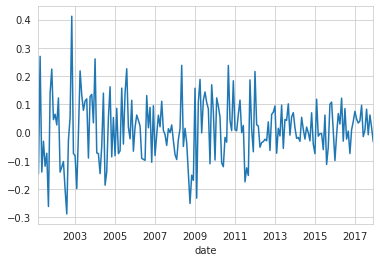

In [86]:
cnn_data.loc["A","label"].plot()

In [28]:
metrics = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T

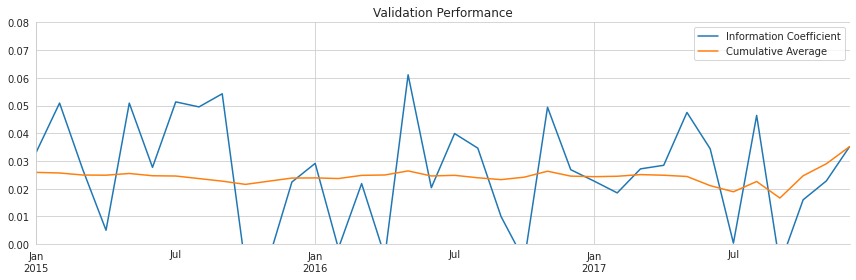

In [29]:
ax = metrics.IC.plot(figsize=(12, 4), 
                     label='Information Coefficient',
                     title='Validation Performance',
                    ylim=(0, .08))
metrics.IC.expanding().mean().plot(ax=ax, label='Cumulative Average')
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'cnn_ts1d_ic', dpi=300);